In [1]:
import numpy as np

from openptv_python.calibration import Calibration, read_calibration
from openptv_python.correspondences import (
    consistent_pair_matching,
    correspondences,
    match_pairs,
    py_correspondences,
    safely_allocate_adjacency_lists,
    safely_allocate_target_usage_marks,
)
from openptv_python.epi import Coord2d
from openptv_python.imgcoord import img_coord
from openptv_python.parameters import (
    ControlPar,
    read_control_par,
    read_volume_par,
)
from openptv_python.tracking_frame_buf import (
    Frame,
    match_coords,
    TargetArray,
    n_tupel,
    read_targets,
)
from openptv_python.trafo import dist_to_flat, metric_to_pixel, pixel_to_metric
from openptv_python.constants import MAXCAND


In [28]:
from openptv_python.calibration import mmlut
mmlut = mmlut()
print(mmlut, mmlut.data)

mmlut(origin=array([0., 0., 0.]), nr=0, nz=0, rw=0, data=None) None


In [2]:
def read_all_calibration(num_cams):
    """Read all calibration files."""
    ori_tmpl = "testing_fodder/cal/sym_cam%d.tif.ori"
    added_name = "testing_fodder/cal/cam1.tif.addpar"

    calib = []
    for cam in range(num_cams):
        ori_name = ori_tmpl % (cam + 1)
        cal = read_calibration(ori_name, added_name)
        calib.append(cal)

    return calib


In [3]:
cpar = read_control_par("testing_fodder/parameters/ptv.par")
vpar = read_volume_par("testing_fodder/parameters/criteria.par")

cpar.num_cams = 2
cpar.mm.n2[0] = 1.0001
cpar.mm.n3 = 1.0001

In [4]:
cpar

ControlPar(num_cams=2, img_base_name=['dumbbell/cam1_Scene77_4085', 'dumbbell/cam2_Scene77_4085', 'dumbbell/cam3_Scene77_4085', 'dumbbell/cam4_Scene77_4085'], cal_img_base_name=['cal/cam1.tif', 'cal/cam2.tif', 'cal/cam3.tif', 'cal/cam4.tif'], hp_flag=1, allCam_flag=0, tiff_flag=1, imx=1280, imy=1024, pix_x=0.017, pix_y=0.017, chfield=0, mm=<openptv_python.parameters.MultimediaPar object at 0x7fcebacbb7c0>)

In [5]:
calib = read_all_calibration(cpar.num_cams)
calib

[Calibration(ext_par=Exterior(x0=-250.0, y0=1.0, z0=250.0, omega=0.0, phi=-0.785, kappa=0.0, dm=array([[ 0.9392483,  0.02633  , -0.342227 ],
        [ 0.0288852,  0.9874532,  0.1552479],
        [ 0.3420208, -0.1557016,  0.9267032]])), int_par=Interior(xh=0.0, yh=0.0, cc=100.0), glass_par=Glass(vec_x=0.0001, vec_y=1e-05, vec_z=100.0), added_par=ap_52(k1=0.0, k2=0.0, k3=0.0, p1=0.0, p2=0.0, scx=1.0, she=0.0), mmlut=mmlut(origin=array([0., 0., 0.]), nr=0, nz=0, rw=0, data=None)),
 Calibration(ext_par=Exterior(x0=250.0, y0=1.0, z0=250.0, omega=0.0, phi=0.785, kappa=0.0, dm=array([[ 0.973711 , -0.0296651,  0.2258471],
        [-0.0150095,  0.980973 ,  0.193563 ],
        [-0.227292 , -0.1918643,  0.9547389]])), int_par=Interior(xh=0.0, yh=0.0, cc=100.0), glass_par=Glass(vec_x=0.0001, vec_y=1e-05, vec_z=100.0), added_par=ap_52(k1=0.0, k2=0.0, k3=0.0, p1=0.0, p2=0.0, scx=1.0, she=0.0), mmlut=mmlut(origin=array([0., 0., 0.]), nr=0, nz=0, rw=0, data=None))]

In [6]:
def generate_test_set(calib, cpar):
    """
    Generate data for targets on 4 cameras.

    The targets are organized on a 4x4 grid, 10 mm apart.
    """
    frm = Frame(cpar.num_cams, 16)

    # Four cameras on 4 quadrants looking down into a calibration target.
    # Calibration taken from an actual experimental setup
    for cam in range(cpar.num_cams):
        frm.num_targets[cam] = 16

        # Construct a scene representing a calibration target, generate
        # targets for it, then use them to reconstruct correspondences.
        for cpt_horz in range(4):
            for cpt_vert in range(4):
                cpt_ix = cpt_horz * 4 + cpt_vert
                if cam % 2:
                    cpt_ix = 15 - cpt_ix  # Avoid symmetric case

                targ = frm.targets[cam][cpt_ix]
                targ.pnr = cpt_ix

                tmp = np.r_[cpt_vert * 10, cpt_horz * 10, 0]
                # print(tmp)
                targ.x, targ.y = img_coord(tmp, calib[cam], cpar.mm)
                print(targ.x, targ.y)
                targ.x, targ.y = metric_to_pixel(targ.x, targ.y, cpar)
                print(targ.x, targ.y)

                # These values work in check_epi, so used here too
                targ.n = 25
                targ.nx = targ.ny = 5
                targ.sumg = 10

    return frm

In [7]:
calib[0]

Calibration(ext_par=Exterior(x0=-250.0, y0=1.0, z0=250.0, omega=0.0, phi=-0.785, kappa=0.0, dm=array([[ 0.9392483,  0.02633  , -0.342227 ],
       [ 0.0288852,  0.9874532,  0.1552479],
       [ 0.3420208, -0.1557016,  0.9267032]])), int_par=Interior(xh=0.0, yh=0.0, cc=100.0), glass_par=Glass(vec_x=0.0001, vec_y=1e-05, vec_z=100.0), added_par=ap_52(k1=0.0, k2=0.0, k3=0.0, p1=0.0, p2=0.0, scx=1.0, she=0.0), mmlut=mmlut(origin=array([0., 0., 0.]), nr=0, nz=0, rw=0, data=None))

In [8]:
frm = generate_test_set(calib, cpar)

47.03845728700088 14.026974951089299
3406.968075705934 -313.11617359348816
49.46477069142148 13.959403298594298
3549.692393613028 -309.1413705055469
51.839881728728834 13.893257565281464
3689.404807572284 -305.2504450165567
54.16539518361826 13.828493059989702
3826.1997166834267 -301.44076823468833
47.36115313258867 17.22260225596565
3425.9501842699215 -501.09425035092056
49.795807462175524 17.12045235573067
3569.1651448338544 -495.0854326900394
52.17883619972992 17.02046887314714
3709.343305866466 -489.2040513615965
54.5118650949618 16.92258358520549
3846.580299703635 -483.4460932473818
47.68704565482792 20.449803339564614
3445.1203326369364 -690.929608209683
50.13008824295316 20.312397167150802
3588.828720173715 -682.8468921853412
52.5210769082569 20.17791952350155
3729.475112250406 -674.9364425589147
54.861658727711784 20.046277744839127
3867.156395747752 -667.1928085199486
48.01618256287282 23.70904943087626
3464.481327227813 -882.6499665221329
50.46766092639351 23.535693862027564


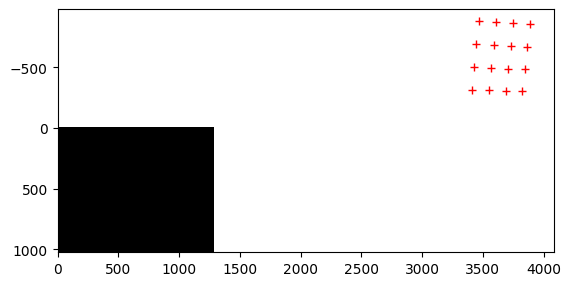

In [26]:
# visualize frames on sort of images
im1 = np.zeros((cpar.imy, cpar.imx))
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(im1, cmap='gray')
for i in frm.targets[0]:
    plt.plot(i.x, i.y, 'r+')

In [10]:
frm.targets

[[Target(pnr=0, x=3406.968075705934, y=-313.11617359348816, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=1, x=3549.692393613028, y=-309.1413705055469, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=2, x=3689.404807572284, y=-305.2504450165567, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=3, x=3826.1997166834267, y=-301.44076823468833, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=4, x=3425.9501842699215, y=-501.09425035092056, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=5, x=3569.1651448338544, y=-495.0854326900394, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=6, x=3709.343305866466, y=-489.2040513615965, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=7, x=3846.580299703635, y=-483.4460932473818, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=8, x=3445.1203326369364, y=-690.929608209683, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=9, x=3588.828720173715, y=-682.8468921853412, n=25, nx=5, ny=5, sumg=10, tnr=0),
  Target(pnr=10, x=3729.475112250406, y=-674.936442558

In [11]:
def correct_frame(frm, calib, cpar, tol):
    """
    Perform the transition from pixel to metric to flat coordinates.

    and x-sorting as required by the correspondence code.

    Arguments:
    ---------
    frm - target information for all cameras.
    cpar - parameters of image size, pixel size etc.
    tol - tolerance parameter for iterative flattening phase, see
        trafo.h:correct_brown_affine_exact().
    """
    corrected = []
    for cam in range(cpar.num_cams):
        corrected.append([])
        for part in range(frm.num_targets[cam]):
            x, y = pixel_to_metric(
                frm.targets[cam][part].x, frm.targets[cam][part].y, cpar
            )
            x, y = dist_to_flat(x, y, calib[cam], tol)

            corrected[cam].append(Coord2d(pnr=None, x=x, y=y))
            corrected[cam][part].pnr = frm.targets[cam][part].pnr

        # This is expected by find_candidate()
        corrected[cam].sort(key=lambda coord: coord.x)

    return corrected


In [12]:

def test_file_not_found(self):
    """Read a nonexistent control.par file."""
    with self.assertRaises(FileNotFoundError):
        read_control_par("nonexistent_file.txt")


In [13]:

def test_valid_file(self):
    """Read a valid control.par file."""
    expected = ControlPar(num_cams=4)
    expected.img_base_name = [
        "dumbbell/cam1_Scene77_4085",
        "dumbbell/cam2_Scene77_4085",
        "dumbbell/cam3_Scene77_4085",
        "dumbbell/cam4_Scene77_4085",
    ]
    expected.cal_img_base_name = [
        "cal/cam1.tif",
        "cal/cam2.tif",
        "cal/cam3.tif",
        "cal/cam4.tif",
    ]
    expected.hp_flag = 1
    expected.allCam_flag = 0
    expected.tiff_flag = 1
    expected.imx = 1280
    expected.imy = 1024
    expected.pix_x = 0.017
    expected.pix_y = 0.017
    expected.chfield = 0
    expected.mm.n1 = 1.49
    expected.mm.n2 = 1.33
    expected.mm.n3 = 5.0
    expected.mm.d = 0.0

    result = read_control_par("tests/testing_folder/corresp/valid.par")
    self.assertEqual(result, expected)


In [14]:

def test_instantiate(self):
    """Creating a MatchedCoords object."""
    cal = Calibration()
    cal.from_file(
        "tests/testing_folder/calibration/cam1.tif.ori",
        "tests/testing_folder/calibration/cam2.tif.addpar",
    )
    cpar = read_control_par("tests/testing_folder/corresp/control.par")
    targs = read_targets("tests/testing_folder/frame/cam1.", 333)

    mc = match_coords(targs, cpar, cal)
    pos, pnr = mc.as_arrays()

    # x sorted?
    assert np.all(pos[1:, 0] > pos[:-1, 0])

    # Manually verified order for the loaded data:
    np.testing.assert_array_equal(
        pnr, np.r_[6, 11, 10, 8, 1, 4, 7, 0, 2, 9, 5, 3, 12]
    )


In [15]:

def test_full_corresp(self):
    """Full scene correspondences."""
    cpar = read_control_par("tests/testing_folder/corresp/control.par")
    vpar = read_volume_par("tests/testing_folder/corresp/criteria.par")

    # Cameras are at so high angles that opposing cameras don't see each
    # other in the normal air-glass-water setting.
    cpar.mm.set_layers([1.0001], [1.0])
    cpar.mm.n3 = 1.0001

    cals = []
    img_pts = []
    corrected = []
    for c in range(cpar.num_cams):
        cal = Calibration()
        cal.from_file(
            f"tests/testing_folder/calibration/sym_cam{c+1:d}.tif.ori",
            "tests/testing_folder/calibration/cam1.tif.addpar",
        )
        cals.append(cal)

        # Generate test targets.
        ta = TargetArray(16)
        for row, col in np.ndindex(4, 4):
            targ_ix = row * 4 + col
            # Avoid symmetric case:
            if c % 2:
                targ_ix = 15 - targ_ix
            targ = ta[targ_ix]

            pos3d = 10 * np.array([col, row, 0], dtype=np.float64)
            x, y = img_coord(pos3d, cal, cpar.mm)
            x, y = metric_to_pixel(x, y, cpar)
            targ.set_pos((x, y))

            targ.set_pnr(targ_ix)
            targ.set_pixel_counts(25, 5, 5)
            targ.set_sum_grey_value(10)

        img_pts.append(ta)
        mc = match_coords(ta, cpar, cal)
        corrected.append(mc)

    _, _, num_targs = correspondences(img_pts, corrected, vpar, cpar, cals, mc)
    assert num_targs == 16


In [16]:

def test_single_cam_corresp(self):
    """Single camera correspondence."""
    cpar = read_control_par("tests/testing_folder/single_cam/parameters/ptv.par")
    vpar = read_volume_par(
        "tests/testing_folder/single_cam/parameters/criteria.par"
    )

    # Cameras are at so high angles that opposing cameras don't see each
    # other in the normal air-glass-water setting.
    cpar.mm.set_layers([1.0], [1.0])
    cpar.n3 = 1.0

    cals = []
    img_pts = []
    corrected = []
    cal = Calibration()
    cal.from_file(
        "tests/testing_folder/single_cam/calibration/cam_1.tif.ori",
        "tests/testing_folder/single_cam/calibration/cam_1.tif.addpar",
    )
    cals.append(cal)

    # Generate test targets.
    targs = TargetArray(9)
    for row, col in np.ndindex(3, 3):
        targ_ix = row * 3 + col
        targ = targs[targ_ix]

        pos3d = 10 * np.r_[col, row, 0]
        x, y = img_coord(pos3d, cal, cpar.mm)
        x, y = metric_to_pixel(x, y, cpar)
        targ.set_pos((x, y))

        targ.set_pnr(targ_ix)
        targ.set_pixel_counts(25, 5, 5)
        targ.set_sum_grey_value(10)

    img_pts.append(targs)
    mc = match_coords(targs, cpar, cal)
    corrected.append(mc)

    sorted_pos, sorted_corresp, num_targs = py_correspondences(
        img_pts, corrected, cals, vpar, cpar
    )

    self.assertEqual(len(sorted_pos), 1)  # 1 camera
    self.assertEqual(sorted_pos[0].shape, (1, 9, 2))
    np.testing.assert_array_equal(
        sorted_corresp[0][0], np.r_[6, 3, 0, 7, 4, 1, 8, 5, 2]
    )
    self.assertEqual(num_targs, 9)


In [17]:

def test_two_camera_matching(self):
    """Setup is the same as the 4-camera test, targets are darkened in two cameras to get 16 pairs."""

    cpar = read_control_par("tests/testing_fodder/parameters/ptv.par")
    vpar = read_volume_par("tests/testing_fodder/parameters/criteria.par")

    cpar.num_cams = 2
    cpar.mm.n2[0] = 1.0
    cpar.mm.n3 = 1.0
    
    
    vpar.Zmin_lay[0] = -1
    vpar.Zmin_lay[1] = -1
    vpar.Zmax_lay[0] = 1
    vpar.Zmax_lay[1] = 1

    calib = read_all_calibration(cpar)
    frm = generate_test_set(calib, cpar)

    corrected = correct_frame(frm, calib, cpar, 0.0001)
    corr_lists = safely_allocate_adjacency_lists(cpar.num_cams, frm.num_targets)
    match_pairs(corr_lists, corrected, frm, vpar, cpar, calib)
    
    # Assert each target has the real matches as candidates
    for cam in range(cpar.num_cams - 1):
        for subcam in range(cam + 1, cpar.num_cams):
            for part in range(frm.num_targets[cam]):
                correct_pnr = (
                    corrected[cam][corr_lists[cam][subcam][part].p1].pnr
                    if (subcam - cam) % 2 == 0 else
                    15 - corrected[cam][corr_lists[cam][subcam][part].p1].pnr
                )
                found_correct_pnr = False
                for cand in range(MAXCAND):
                    if (corrected[subcam][corr_lists[cam][subcam][part].p2[cand]].pnr == correct_pnr):
                        found_correct_pnr = True
                        break
                self.assertTrue(found_correct_pnr)         

    # continue to the consistent_pair matching test
    con = [n_tupel() for _ in range(4 * 16)]
    tusage = safely_allocate_target_usage_marks(cpar.num_cams)

    # high accept corr bcz of closeness to epipolar lines.
    matched = consistent_pair_matching(
        corr_lists, cpar.num_cams, frm.num_targets, 10000.0, con, 4 * 16, tusage
    )

    assert matched == 16
    


In [18]:

    # def test_correspondences(self):
    #     """Test correspondences function."""
    #     frm = None
    #     match_counts = [0] * 4

    #     cpar = read_control_par("tests/testing_fodder/parameters/ptv.par")
    #     vpar = read_volume_par("tests/testing_fodder/parameters/criteria.par")

    #     # Cameras are at so high angles that opposing cameras don't see each other
    #     # in the normal air-glass-water setting.
    #     cpar.mm.n2[0] = 1.0001
    #     cpar.mm.n3 = 1.0001

    #     calib = read_all_calibration(cpar)
    #     frm = generate_test_set(calib, cpar)
    #     corrected = correct_frame(frm, calib, cpar, 0.0001)
    #     _ = correspondences(frm, corrected, vpar, cpar, calib, match_counts)

    #     # The example set is built to have all 16 quadruplets.
    #     assert match_counts[0] == 16
    #     assert match_counts[1] == 0
    #     assert match_counts[2] == 0
    #     assert match_counts[3] == 16  # last element is the sum of matches



In [19]:

def test_correct_list_size(self):
    num_cams = 5
    target_counts = [3, 5, 2, 4, 1]
    lists = safely_allocate_adjacency_lists(num_cams, target_counts)
    self.assertEqual(len(lists), num_cams)
    for i in range(num_cams):
        self.assertEqual(len(lists[i]), num_cams)
        for j in range(num_cams):
            if i < j:
                self.assertEqual(len(lists[i][j]), target_counts[i])


In [20]:

def test_correct_list_size(self):
    num_cams = 5
    target_counts = [3, 5, 2, 4, 1]
    lists = safely_allocate_adjacency_lists(num_cams, target_counts)
    self.assertEqual(len(lists), num_cams)
    for i in range(num_cams):
        self.assertEqual(len(lists[i]), num_cams)
        for j in range(num_cams):
            if i < j:
                self.assertEqual(len(lists[i][j]), target_counts[i])


In [21]:

def test_memory_error(self):
    """Memory stress test."""
    # available_memory = 8GB = 8 * 1024 * 1024 * 1024 bytes
    # overhead = 200MB = 200 * 1024 * 1024 bytes
    # item_size = 4 bytes (for integers)

    # max_items = (8 * 1024 * 1024 * 1024 - 200 * 1024 * 1024) // 4 = 1,995,116,800

    num_cams = 4
    target_counts = [1000, 1000, 1000, 1000]
    # with self.assertRaises(MemoryError):
    _ = safely_allocate_adjacency_lists(num_cams, target_counts)

    # target_counts = [int(1e3), int(1e3), int(1e3), int(1e10)]
    # with self.assertRaises(MemoryError):
    #     safely_allocate_adjacency_lists(num_cams, target_counts)


In [22]:

def test_two_camera_matching(self):
    """Setup is the same as the 4-camera test, targets are darkened in two cameras to get 16 pairs."""

    cpar = read_control_par("tests/testing_fodder/parameters/ptv.par")
    vpar = read_volume_par("tests/testing_fodder/parameters/criteria.par")

    cpar.num_cams = 2
    cpar.mm.n2[0] = 1.0
    cpar.mm.n3 = 1.0
    
    
    vpar.Zmin_lay[0] = -1
    vpar.Zmin_lay[1] = -1
    vpar.Zmax_lay[0] = 1
    vpar.Zmax_lay[1] = 1

    calib = read_all_calibration(cpar)
    frm = generate_test_set(calib, cpar)

    corrected = correct_frame(frm, calib, cpar, 0.0001)
    corr_lists = safely_allocate_adjacency_lists(cpar.num_cams, frm.num_targets)
    match_pairs(corr_lists, corrected, frm, vpar, cpar, calib)
    
    # Assert each target has the real matches as candidates
    for cam in range(cpar.num_cams - 1):
        for subcam in range(cam + 1, cpar.num_cams):
            for part in range(frm.num_targets[cam]):
                correct_pnr = (
                    corrected[cam][corr_lists[cam][subcam][part].p1].pnr
                    if (subcam - cam) % 2 == 0 else
                    15 - corrected[cam][corr_lists[cam][subcam][part].p1].pnr
                )
                found_correct_pnr = False
                for cand in range(MAXCAND):
                    if (corrected[subcam][corr_lists[cam][subcam][part].p2[cand]].pnr == correct_pnr):
                        found_correct_pnr = True
                        break
                self.assertTrue(found_correct_pnr)         

    # continue to the consistent_pair matching test
    con = [n_tupel() for _ in range(4 * 16)]
    tusage = safely_allocate_target_usage_marks(cpar.num_cams)

    # high accept corr bcz of closeness to epipolar lines.
    matched = consistent_pair_matching(
        corr_lists, cpar.num_cams, frm.num_targets, 10000.0, con, 4 * 16, tusage
    )

    assert matched == 16
    


In [23]:

    # def test_correspondences(self):
    #     """Test correspondences function."""
    #     frm = None
    #     match_counts = [0] * 4

    #     cpar = read_control_par("tests/testing_fodder/parameters/ptv.par")
    #     vpar = read_volume_par("tests/testing_fodder/parameters/criteria.par")

    #     # Cameras are at so high angles that opposing cameras don't see each other
    #     # in the normal air-glass-water setting.
    #     cpar.mm.n2[0] = 1.0001
    #     cpar.mm.n3 = 1.0001

    #     calib = read_all_calibration(cpar)
    #     frm = generate_test_set(calib, cpar)
    #     corrected = correct_frame(frm, calib, cpar, 0.0001)
    #     _ = correspondences(frm, corrected, vpar, cpar, calib, match_counts)

    #     # The example set is built to have all 16 quadruplets.
    #     assert match_counts[0] == 16
    #     assert match_counts[1] == 0
    #     assert match_counts[2] == 0
    #     assert match_counts[3] == 16  # last element is the sum of matches


In [24]:


def test_correct_list_size(self):
    num_cams = 5
    target_counts = [3, 5, 2, 4, 1]
    lists = safely_allocate_adjacency_lists(num_cams, target_counts)
    self.assertEqual(len(lists), num_cams)
    for i in range(num_cams):
        self.assertEqual(len(lists[i]), num_cams)
        for j in range(num_cams):
            if i < j:
                self.assertEqual(len(lists[i][j]), target_counts[i])


In [25]:

def test_memory_error(self):
    """Memory stress test."""
    # available_memory = 8GB = 8 * 1024 * 1024 * 1024 bytes
    # overhead = 200MB = 200 * 1024 * 1024 bytes
    # item_size = 4 bytes (for integers)

    # max_items = (8 * 1024 * 1024 * 1024 - 200 * 1024 * 1024) // 4 = 1,995,116,800

    num_cams = 4
    target_counts = [1000, 1000, 1000, 1000]
    # with self.assertRaises(MemoryError):
    _ = safely_allocate_adjacency_lists(num_cams, target_counts)

    # target_counts = [int(1e3), int(1e3), int(1e3), int(1e10)]
    # with self.assertRaises(MemoryError):
    #     safely_allocate_adjacency_lists(num_cams, target_counts)
